In [1]:
!nvidia-smi

Fri Jan  9 11:47:10 2026       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 590.48.01              Driver Version: 590.48.01      CUDA Version: 13.1     |
+-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 4060 ...    Off |   00000000:01:00.0  On |                  N/A |
| N/A   46C    P8              5W /   60W |    1495MiB /   8188MiB |     87%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [2]:
# %pip install "plotly[express]"

/home/yuki/Code/Python/pipellm/.venv/bin/python: No module named pip
Note: you may need to restart the kernel to use updated packages.


In [ ]:
# install numpy required by plotly.express (runs in the notebook environment)
import plotly.express as px
from collections import defaultdict
import uuid
from datetime import datetime, timezone
import os
import re

In [11]:
class CharTokenizer:
    def __init__(self, training_data: str = "the quick brown fox jumps over the lazy dog"):
        self.training_data = training_data
        self.fit()

    def fit(self):
        self.vocab = sorted(set(self.training_data))
        self.char_to_id = {char: idx for idx, char in enumerate(self.vocab)}
        self.id_to_char = {idx: char for idx, char in enumerate(self.vocab)}
        self.vocab_size = len(self.vocab)

    def plot_token_distribution(self, label: str = None):
        counter = defaultdict(int)
        for token in self.encode(self.training_data):
            counter[token] += 1
        freq = [counter[self.char_to_id[char]] for char in self.vocab]
        fig = px.bar(x=self.vocab, y=freq, labels={'x': 'Token', 'y': 'Frequency'}, width=800, height=300)
        fig.write_html(f"logs/plot_{label}.html", include_plotlyjs="cdn")
        fig.show()

    def get_compression_ratio(self):
        num_bytes = len(bytes(self.training_data, encoding="utf-8"))
        num_tokens = len(self.encode(self.training_data))
        return num_bytes / num_tokens

    def encode(self, text: str):
        return [self.char_to_id[char] if char in self.char_to_id else '<unk>' for char in text]

    def decode(self, ids: list):
        return ''.join([self.id_to_char[id_] if type(id_) is int else '<unk>' for id_ in ids])

tk = CharTokenizer()
print(tk.vocab_size, tk.vocab)
print(tk.encode("hi, how are you?"))
print(tk.decode(tk.encode("hi, how are you?")))
print('Compression ratio', tk.get_compression_ratio())
tk.plot_token_distribution(label="hello")

with open("../data/the-verdict.txt", "r") as f:
    data = f.read()
tk = CharTokenizer(data)
print(tk.vocab_size, tk.vocab)
print(tk.encode("hi, how are you?"))
print(tk.decode(tk.encode("hi, how are you?")))
print('Compression ratio', tk.get_compression_ratio())
tk.plot_token_distribution(label="the-verdict")

27 [' ', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']
[8, 9, '<unk>', 0, 8, 15, 23, 0, 1, 18, 5, 0, 25, 15, 21, '<unk>']
hi<unk> how are you<unk>
Compression ratio 1.0


62 ['\n', ' ', '!', '"', "'", '(', ')', ',', '-', '.', ':', ';', '?', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'L', 'M', 'N', 'O', 'P', 'R', 'S', 'T', 'U', 'V', 'W', 'Y', '_', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']
[43, 44, 7, 1, 43, 50, 58, 1, 36, 53, 40, 1, 60, 50, 56, 12]
hi, how are you?
Compression ratio 1.0


In [12]:
from rich.progress import track
import matplotlib.pyplot as plt


class BPETokenizer(CharTokenizer):
    def __init__(self, training_data: str = "the quick brown fox jumps over the lazy dog", num_merges: int = 10, verbose=False):
        self.num_merges = num_merges
        self.verbose = verbose
        super().__init__(training_data)

    def fit(self):
        self.training_data_bytes = list(self.training_data.encode('utf-8'))
        self.vocab_size = 256
        self.vocab = [chr(i) for i in range(self.vocab_size)]
        self.char_to_id = {char: idx for idx, char in enumerate(self.vocab)}
        self.id_to_char = {idx: char for idx, char in enumerate(self.vocab)}
        self.compression_ratios = [1.0] 

        for _ in track(range(self.num_merges), description="Training BPE..."):
            pair_counts = defaultdict(int)
            
            # count pairs
            for i in range(len(self.training_data_bytes) - 1):
                pair = (self.training_data_bytes[i], self.training_data_bytes[i + 1])
                pair_counts[pair] += 1

            max_pair = max(pair_counts, key=pair_counts.get)            
            self.vocab.append(''.join([self.id_to_char[max_pair[0]], self.id_to_char[max_pair[1]]]))
            if self.verbose:
                print('Training data so far', [self.id_to_char[b] for b in self.training_data_bytes[:50]])
                print('Top 10 pairs', [(self.id_to_char[c1], self.id_to_char[c2], count) for ((c1, c2), count) in [sorted(pair_counts.items(), key=lambda x: x[1], reverse=True)[:10]][0]])
                print(f'New token "{self.vocab[-1]}"')
            self.vocab_size += 1
            self.char_to_id[self.vocab[-1]] = self.vocab_size - 1
            self.id_to_char[self.vocab_size - 1] = self.vocab[-1]

            # merge pair in training data
            new_data = []
            i = 0
            while i < len(self.training_data_bytes):
                if i < len(self.training_data_bytes) - 1 and (self.training_data_bytes[i], self.training_data_bytes[i + 1]) == max_pair:
                    new_data.append(self.vocab_size - 1)
                    i += 2
                else:
                    new_data.append(self.training_data_bytes[i])
                    i += 1
            self.training_data_bytes = new_data

            # calculate compression ratio
            self.compression_ratios.append(self.get_compression_ratio())

    def plot_compression_ratios(self):
        plt.figure(figsize=(8, 3))
        plt.plot(range(len(self.compression_ratios)), self.compression_ratios, marker='o')
        plt.xlabel("Number of Merges")
        plt.ylabel("Compression Ratio")
        plt.title("Compression Ratio vs Number of Merges")
        plt.grid(True, linestyle='--', alpha=0.6)
        plt.tight_layout()
        plt.show()
        
    def encode(self, text: str):
        tokens = []
        i = 0
        while i < len(text):
            match = None
            for j in range(self.vocab_size - 1, -1, -1):
                token = self.id_to_char[j]
                if text.startswith(token, i):
                    match = token
                    break
            if match:
                tokens.append(self.char_to_id[match])
                i += len(match)
            else:
                tokens.append('<unk>')
                i += 1
        return tokens

    def decode(self, ids: list):
        return ''.join([self.id_to_char[id_] if type(id_) is int else '<unk>' for id_ in ids])

tk = BPETokenizer(num_merges=2, verbose=True)

Output()

Training data so far ['t', 'h', 'e', ' ', 'q', 'u', 'i', 'c', 'k', ' ', 'b', 'r', 'o', 'w', 'n', ' ', 'f', 'o', 
'x', ' ', 'j', 'u', 'm', 'p', 's', ' ', 'o', 'v', 'e', 'r', ' ', 't', 'h', 'e', ' ', 'l', 'a', 'z', 'y', ' ', 'd', 
'o', 'g']

Top 10 pairs [('t', 'h', 2), ('h', 'e', 2), ('e', ' ', 2), (' ', 'q', 1), ('q', 'u', 1), ('u', 'i', 1), ('i', 'c', 
1), ('c', 'k', 1), ('k', ' ', 1), (' ', 'b', 1)]

New token "th"

Training data so far ['th', 'e', ' ', 'q', 'u', 'i', 'c', 'k', ' ', 'b', 'r', 'o', 'w', 'n', ' ', 'f', 'o', 'x', ' 
', 'j', 'u', 'm', 'p', 's', ' ', 'o', 'v', 'e', 'r', ' ', 'th', 'e', ' ', 'l', 'a', 'z', 'y', ' ', 'd', 'o', 'g']

Top 10 pairs [('th', 'e', 2), ('e', ' ', 2), (' ', 'q', 1), ('q', 'u', 1), ('u', 'i', 1), ('i', 'c', 1), ('c', 'k',
1), ('k', ' ', 1), (' ', 'b', 1), ('b', 'r', 1)]

New token "the"

In [13]:
with open("../data/the-verdict.txt", "r") as f:
    data = f.read()
tk = BPETokenizer(data, num_merges=350)
print(tk.vocab_size, tk.vocab)
print(tk.encode("hi, how are you?"))
print(tk.decode(tk.encode("hi, how are you?")))
print('Compression ratio', tk.get_compression_ratio())
print('Added tokens ', tk.vocab[256:])
tk.plot_token_distribution(label="BPE Compression ratio")

Output()

606 ['\x00', '\x01', '\x02', '\x03', '\x04', '\x05', '\x06', '\x07', '\x08', '\t', '\n', '\x0b', '\x0c', '\r', '\x0e', '\x0f', '\x10', '\x11', '\x12', '\x13', '\x14', '\x15', '\x16', '\x17', '\x18', '\x19', '\x1a', '\x1b', '\x1c', '\x1d', '\x1e', '\x1f', ' ', '!', '"', '#', '$', '%', '&', "'", '(', ')', '*', '+', ',', '-', '.', '/', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', ':', ';', '<', '=', '>', '?', '@', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', '[', '\\', ']', '^', '_', '`', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', '{', '|', '}', '~', '\x7f', '\x80', '\x81', '\x82', '\x83', '\x84', '\x85', '\x86', '\x87', '\x88', '\x89', '\x8a', '\x8b', '\x8c', '\x8d', '\x8e', '\x8f', '\x90', '\x91', '\x92', '\x93', '\x94', '\x95', '\x96', '\x97', '\x98', '\x99', '\x9a', '\x9b', '\x9c', '\x9d', '\x9e', '\x9f', '\xa0

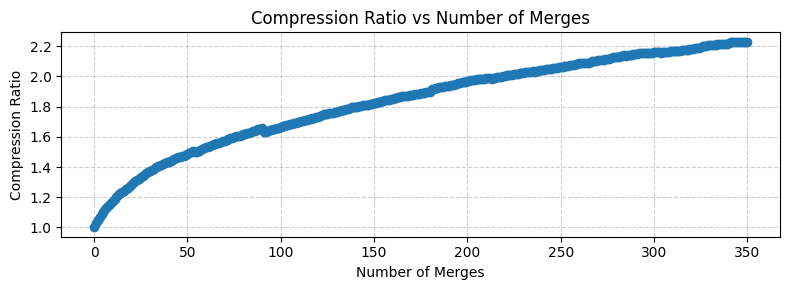

In [14]:
tk.plot_compression_ratios()

In [15]:
import tiktoken

enc = tiktoken.get_encoding('r50k_base')

print("Vocab size", enc.n_vocab)
print("Compression ratio", len(bytes(data, encoding="utf-8")) / len(enc.encode(data)))

Vocab size 50257
Compression ratio 3.980369290573372


In [16]:
encoding = enc.encode("the quick brown fox <|endoftext|> jumps over the lazy dog", allowed_special={'<|endoftext|>'})
print(encoding)
print([enc.decode([token]) for token in encoding])

[1169, 2068, 7586, 21831, 220, 50256, 18045, 625, 262, 16931, 3290]
['the', ' quick', ' brown', ' fox', ' ', '<|endoftext|>', ' jumps', ' over', ' the', ' lazy', ' dog']
